### HW5: Toxic Comment Classification with Spark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import FMClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MultilabelClassificationEvaluator
import tqdm
import pandas as pd

Start spark local session

In [3]:
spark = SparkSession.builder\
        .master('local[32]')\
        .appName('HW5')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sc = spark.sparkContext

Read data

In [4]:
train = spark.read.csv('train.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = spark.read.csv('test.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test_labels = spark.read.csv('test_labels.csv', sep=',', quote='\"', escape='\"', multiLine=True, header=True, inferSchema=True)
test = test.join(test_labels, 'id')

Train model

In [14]:
targets = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',]
res = {
    'numFeatures':[],
    'pipe':[],
    #'model':[],
}

res.update({
    target:[] for target in targets
})

for numFeatures in tqdm.tqdm([10, 20, 50, 100]):
#for numFeatures in tqdm.tqdm([100]):
    scores = []
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
    preprocessing = [tokenizer, hashingTF, idf,]

    pipeline = Pipeline(stages=[tokenizer, hashingTF, idf,])
    res['pipe'].append('tf_idf_logreg')
    res['numFeatures'].append(numFeatures)
    for target in targets:

        model = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target)
        metrics = BinaryClassificationEvaluator(labelCol=model.getLabelCol(), rawPredictionCol=model.getRawPredictionCol())

        pipeline = Pipeline(stages=preprocessing + [model,])
        pipeline = pipeline.fit(train)
        res[target].append(metrics.evaluate(pipeline.transform(test)))

100%|██████████| 1/1 [05:46<00:00, 346.82s/it]


In [15]:
pd.DataFrame(res)

,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,100,tf_idf_logreg,0.722376,0.761274,0.750961,0.788325,0.753461,0.728204


In [7]:
for numFeatures in tqdm.tqdm([10, 20, 50, 100]):
    scores = []
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="tf", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
    preprocessing = [tokenizer, hashingTF, idf,]

    pipeline = Pipeline(stages=[tokenizer, hashingTF, idf,])
    res['pipe'].append('tf_idf_naiveBayes')
    res['numFeatures'].append(numFeatures)
    for target in targets:

        model = NaiveBayes(
                featuresCol=idf.getOutputCol(), 
                labelCol=target, 
                smoothing=1.0, 
                modelType="multinomial")
        metrics = BinaryClassificationEvaluator(labelCol=model.getLabelCol(), rawPredictionCol=model.getRawPredictionCol())

        pipeline = Pipeline(stages=preprocessing + [model,])
        pipeline = pipeline.fit(train)
        res[target].append(metrics.evaluate(pipeline.transform(test)))

pd.DataFrame(res)

100%|██████████| 4/4 [13:41<00:00, 205.48s/it]


,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,10,tf_idf_logreg,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
1,20,tf_idf_logreg,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
2,50,tf_idf_logreg,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
3,100,tf_idf_logreg,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
4,10,tf_idf_naiveBayes,0.640626,0.498888,0.637462,0.595308,0.635330,0.620397
5,20,tf_idf_naiveBayes,0.641366,0.499387,0.638537,0.597254,0.636410,0.622166
6,50,tf_idf_naiveBayes,0.641836,0.504088,0.639044,0.606435,0.637086,0.624230
7,100,tf_idf_naiveBayes,0.642066,0.506713,0.639695,0.608007,0.637777,0.624552


In [16]:
for numFeatures in tqdm.tqdm([10, 20, 50, 100]):
    scores = []
    tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")
    w2v = Word2Vec(inputCol=tokenizer.getOutputCol(), outputCol="features", vectorSize=numFeatures)
    preprocessing = [tokenizer, w2v]

    pipeline = Pipeline(stages=[tokenizer, w2v])
    res['pipe'].append('w2v_logreg')
    res['numFeatures'].append(numFeatures)
    for target in targets:

        model = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target)
        metrics = BinaryClassificationEvaluator(labelCol=model.getLabelCol(), rawPredictionCol=model.getRawPredictionCol())

        pipeline = Pipeline(stages=preprocessing + [model,])
        pipeline = pipeline.fit(train)
        res[target].append(metrics.evaluate(pipeline.transform(test)))

pd.DataFrame(res)

 25%|██▌       | 1/4 [45:35<2:16:46, 2735.62s/it]ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
 25%|██▌       | 1/4 [51:00<2:33:02, 3060.73s/it]


KeyboardInterrupt: ignored

Results

In [23]:
res['numFeatures'] = res['numFeatures'][:2]
res['pipe'] = res['pipe'][:2]

In [31]:
df = pd.DataFrame(res)
df['mean_score'] = df[targets].mean(axis=1)

In [33]:
df

,numFeatures,pipe,toxic,severe_toxic,obscene,threat,insult,identity_hate,mean_score
0,100,tf_idf_logreg,0.722376,0.761274,0.750961,0.788325,0.753461,0.728204,0.750767
1,10,w2v_logreg,0.820167,0.928906,0.854558,0.881078,0.848003,0.878003,0.868452


Text(0.5, 1.0, 'roc_auc')

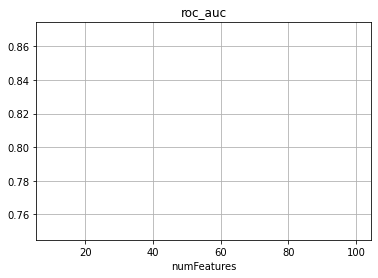

In [36]:
pipe = 'tf_idf_logreg'
ax = df[df['pipe'] == pipe]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': pipe})['mean_score']\
    .plot(grid=True, label=model)

for pipe in ['tf_idf_logreg', 'w2v_logreg']: 
    df[df['pipe'] == pipe]\
    .set_index('numFeatures')\
    .rename(columns={'roc_auc': pipe})['mean_score']\
    .plot(grid=True, label=model, ax=ax)

ax.set_title('roc_auc')